##### Importing Dependencies and dataset

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import os
import librosa
from sklearn.preprocessing import OneHotEncoder

from Utils import AudioUtil

In [3]:
main_dir=os.getcwd()
test_dir=main_dir+'\\test'
print('{}\n{}'.format(main_dir, test_dir))

c:\Users\david\Desktop\LOOP_Q_PRIZE
c:\Users\david\Desktop\LOOP_Q_PRIZE\test


In [26]:
test_df = pd.read_csv(main_dir+'\\2022challengeA_test.csv', index_col=0)
n_samples = len(test_df)

print('Number of rows: {}'.format(test_df.shape[0]))
display(test_df.sample(10))


au = AudioUtil()

Number of rows: 1385


,file_id,origin,predicted_emotion
727,f4825714-603d-4ae8-a190-365a97b3a3e8.wav,crema,NaN
433,b7202182-1c7e-4a7d-912d-28637d2beff1.wav,crema,NaN
1175,e3e706b3-23be-4bc1-ade2-2ee1280a3501.wav,tess,NaN
108,6a08e1b1-dcbf-4752-94f4-a5710be9af32.wav,crema,NaN
1188,bd0170ee-4c07-423c-8444-12ff17ae2e56.wav,tess,NaN
915,7390a5a4-6df3-4b5b-a38f-292bdca75187.wav,ravdess,NaN
1093,08cb8e86-8d39-4809-b6b2-922c9de45c13.wav,tess,NaN
252,d62506af-8a51-47df-bff4-b4e589f77e5d.wav,crema,NaN
1149,47b517d0-1088-45e9-a73f-ca488ac7522a.wav,tess,NaN
303,0ae4a147-94f8-4117-af24-13d57a7a2815.wav,crema,NaN


##### extracting features

In [8]:
# setting the parameters

n_fft = 1024
n_mels = 64
hop_len = int(n_fft / 2)

In [9]:
# inizializing the arrays of the features

# Mel spectrogram
sg = np.zeros(shape = (n_samples, 126, 64))
# MFCCs
mf = np.zeros(shape = (n_samples, 126, 20))
# Chroma gram
cg = np.zeros(shape = (n_samples, 126, 12))
# Tonnetz Representation
tn = np.zeros(shape = (n_samples, 126, 6))
# Spectral contrast
sc = np.zeros(shape = (n_samples, 126, 7))

In [13]:
print('Creating the dataset with the features ...')

for i in range(n_samples):
    audio_file = test_dir + '\\' + test_df.loc[i, 'file_id']
    aud = librosa.load(audio_file)
    aud = au.process_audio(aud)

    mel_sg = au.spectro_gram(aud, n_mels = n_mels, n_fft = n_fft, hop_len = hop_len)
    mfcc = librosa.feature.mfcc(S = mel_sg)
    chroma_gram = librosa.feature.chroma_cqt(y = aud[0], sr = aud[1], hop_length=hop_len)
    tonnetz = librosa.feature.tonnetz(chroma = chroma_gram)
    spectral_contrast = librosa.feature.spectral_contrast(y = aud[0], sr = aud[1], n_fft = n_fft, hop_length = hop_len)

    sg[i] = mel_sg.transpose()
    mf[i] = mfcc.transpose()
    cg[i] = chroma_gram.transpose()
    tn[i] = tonnetz.transpose()
    sc[i] = spectral_contrast.transpose() 

    if i%100==0:
        print (str(['=' for i in range(i//100)]+['>']+['.' for i in range(n_samples//100-i//100)]).replace(',','').replace(' ','').replace("'", ''), end='\r')
print()       

print('Done !!')

Creating the dataset with the features ...
[=============>]
Done !!


In [18]:
X = [sg, mf, cg, tn, sc]

##### Importing model

In [15]:
model = tf.keras.models.load_model('models/multi_input_model')

##### predicting emotions

In [19]:
labels = model.predict(X)

# Trasforming the One Hot Encoded emotions into strings

ems = np.array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sadness','surprise'])
enc = OneHotEncoder()
enc.fit(ems.reshape(-1,1))

predicted_emotions = enc.inverse_transform(labels)

##### Modifying and downloading the final dataset

In [27]:
test_df['predicted_emotion'] = predicted_emotions

In [28]:
test_df.sample(10)

,file_id,origin,predicted_emotion
767,4f14280d-f7a4-4f7d-901f-45e0d4f5752d.wav,crema,angry
799,ae807ecd-c69d-4896-b2a9-fe56bb26d033.wav,crema,neutral
749,e29fd42e-238b-48e9-aa25-d1e7ba080703.wav,crema,disgust
639,ce1544e9-bd8e-4542-97d4-0ce5b0a62d82.wav,crema,happy
1107,3ed6c275-307a-497e-bbc4-f3d22852df8e.wav,tess,sadness
423,d859db96-4436-4775-ae02-3c06f3df1298.wav,crema,disgust
832,a80474a0-39a5-4d76-9bf8-167645192e90.wav,crema,fear
1071,e76c17fc-48e1-46a6-b617-0fe9f4a78167.wav,tess,surprise
1198,ccfe384d-6460-4479-8fbc-ece9e851d981.wav,tess,neutral
1225,3d96b2f3-5cf5-4482-81e7-0c3867d1f4d8.wav,tess,angry


<AxesSubplot:xlabel='predicted_emotion', ylabel='Count'>

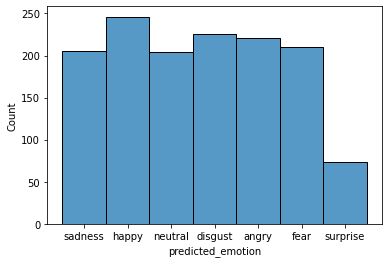

In [33]:
import seaborn as sns

sns.histplot(data = test_df, x = 'predicted_emotion')

In [36]:
test_df.to_csv('Baldelli,Davide_Answers.csv')